In [1]:
import sklearn as tf
import numpy as np

In [28]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disables the decompression bomb warning


In [27]:
from PIL import Image
import os

# Define the input directory (original panoramic images)
input_dir = '/Users/fabriziocontreras/Desktop/KUL/Masters/Second semester/Big data world/images'
# Define the output directory (sliced images)
output_dir = '/Users/fabriziocontreras/Desktop/KUL/Masters/Second semester/Big data world/sliced_images'


# Loop over each class (folder)
for class_name in os.listdir(input_dir):
    class_input_path = os.path.join(input_dir, class_name)
    if os.path.isdir(class_input_path):
        # Create a corresponding folder in the output directory
        class_output_path = os.path.join(output_dir, class_name)
        if not os.path.exists(class_output_path):
            os.makedirs(class_output_path)
        
        # Process each image file in the class folder
        for filename in os.listdir(class_input_path):
            if filename.lower().endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(class_input_path, filename)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        # Define the boxes for slicing the image vertically
                        left_box = (0, 0, width // 2, height)
                        right_box = (width // 2, 0, width, height)
                        
                        left_img = img.crop(left_box)
                        right_img = img.crop(right_box)
                        
                        # Create filenames for the slices
                        base_name, ext = os.path.splitext(filename)
                        left_filename = f"{base_name}_left{ext}"
                        right_filename = f"{base_name}_right{ext}"
                        
                        # Save the sliced images
                        left_img.save(os.path.join(class_output_path, left_filename))
                        right_img.save(os.path.join(class_output_path, right_filename))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = '/Users/fabriziocontreras/Desktop/KUL/Masters/Second semester/Big data world/sliced_images'  # Update with your actual path

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    validation_split=0.2  # Reserve 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),  # Images are resized on the fly
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4237 images belonging to 12 classes.
Found 1057 images belonging to 12 classes.


In [33]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained model without its top layers
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization to prevent overfitting
predictions = Dense(12, activation='softmax')(x)  # Adjust if you have 12 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
####model.fit(train_generator, validation_data=validation_generator, epochs=5)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5  # Adjust the number of epochs as needed
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 1845s 14s/step - accuracy: 0.2321 - loss: 2.4488 - val_accuracy: 0.4257 - val_loss: 1.7237
Epoch 2/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 1834s 14s/step - accuracy: 0.3765 - loss: 1.7633 - val_accuracy: 0.4484 - val_loss: 1.5855
Epoch 3/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 1856s 14s/step - accuracy: 0.4471 - loss: 1.5936 - val_accuracy: 0.4588 - val_loss: 1.5026
Epoch 4/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 1842s 14s/step - accuracy: 0.4606 - loss: 1.4898 - val_accuracy: 0.4976 - val_loss: 1.4007
Epoch 5/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 1856s 14s/step - accuracy: 0.4929 - loss: 1.4128 - val_accuracy: 0.5232 - val_loss: 1.3854


34/34 ━━━━━━━━━━━━━━━━━━━━ 365s 11s/step - accuracy: 0.5182 - loss: 1.4037
Validation Loss: 1.3896
Validation Accuracy: 0.5156
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


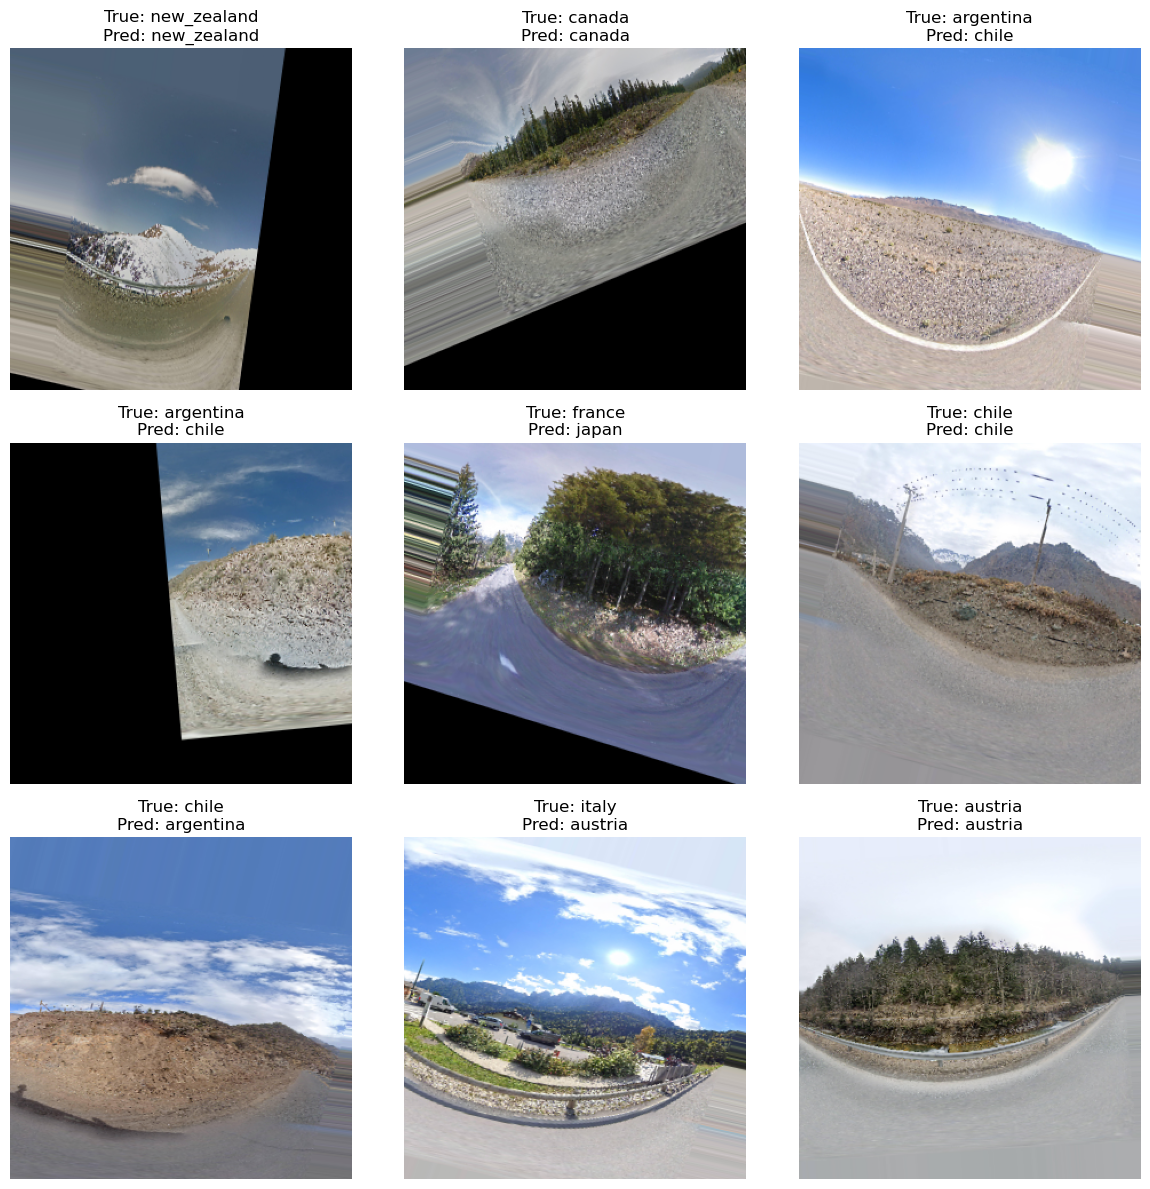

In [37]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on a batch of images
import numpy as np
import matplotlib.pyplot as plt

x_batch, y_batch =next(validation_generator)
predictions = model.predict(x_batch)
predicted_classes = np.argmax(predictions, axis=1)

# Map class indices to labels
class_labels = {v: k for k, v in validation_generator.class_indices.items()}

plt.figure(figsize=(12, 12))
for i in range(9):  # Show 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    true_label = class_labels[np.argmax(y_batch[i])]
    pred_label = class_labels[predicted_classes[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [39]:
# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 362s 11s/step - accuracy: 0.5339 - loss: 1.3741
Validation Loss: 1.3929
Validation Accuracy: 0.5184


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

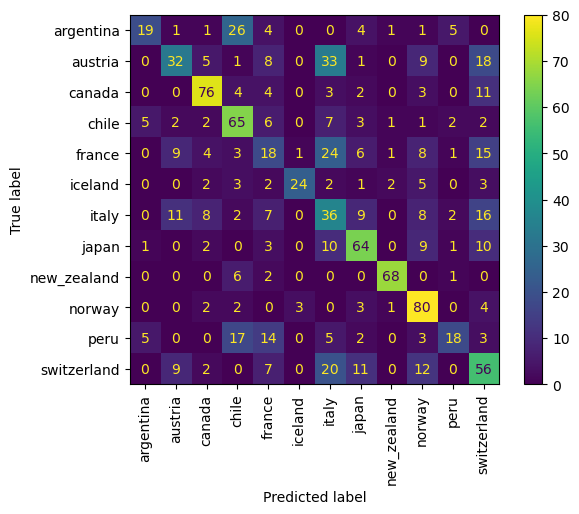

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

# Gather true and predicted labels from the validation generator
for i in range(len(validation_generator)):
    x_batch, y_batch = next(validation_generator)
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(validation_generator.class_indices.keys()))
disp.plot(xticks_rotation='vertical')
plt.show()
